# Importando os dados

In [254]:
import os
import pandas as pd
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir))
sys.path.append(os.path.join(PROJECT_ROOT, 'src'))
from utils.dates import Dates


data_folder = os.path.join(PROJECT_ROOT, 'data', 'raw')
itens_file_name = 'tb_diligencia.csv'
itens_file_path = os.path.join(data_folder, itens_file_name)

#cols = ['idDiligencia', 'idPronac', 'idTipoDiligencia', 'DtSolicitacao', 'idSolicitante', 'DtResposta',
#        'idProponente', 'stEstado', 'idPlanoDistribuicao', 'idArquivo', 'idCodigoDocumentosExigidos',
#        'idProduto', 'stProrrogacao', 'stEnviado']

cols = ['idPronac', 'idTipoDiligencia', 'DtSolicitacao', 'idSolicitante', 'DtResposta', 'idProponente', 'stEnviado']

dt_diligencias = pd.read_csv(itens_file_path, usecols = cols, low_memory=False)
dt_diligencias.head()

,idPronac,idTipoDiligencia,DtSolicitacao,idSolicitante,DtResposta,idProponente,stEnviado
0,115502,124,2009-09-24 16:52:23,2851,2010-01-18 14:39:07,NaN,S
1,114250,124,2009-09-24 18:11:00,2825,2009-10-07 19:45:18,6010.0,S
2,115134,124,2009-09-24 18:13:00,2825,2009-10-07 16:10:21,9553.0,S
3,114399,124,2009-09-24 18:26:00,2845,2009-10-06 09:30:35,9521.0,S
4,115059,124,2009-09-24 18:35:00,2915,2009-10-02 18:01:47,11598.0,S


**Tabela Projetos**

In [255]:
projetos_csv_name = 'projetos.csv'
projetos_csv = os.path.join(data_folder, projetos_csv_name)
date_column = 'DtProtocolo'
dt_projetos = pd.read_csv(projetos_csv, usecols = ['IdPRONAC', date_column], low_memory=False)
dt_projetos[date_column] = pd.to_datetime(dt_projetos[date_column], format = Dates.DATE_INPUT_FORMAT)
dt_projetos.head()

,IdPRONAC,DtProtocolo
0,1,2008-09-12
1,2,2008-09-12
2,3,2008-09-12
3,4,2008-09-03
4,5,2008-09-12


**Números distintos de projetos com pelo menos uma diligência**

In [256]:
projects_with_diligencies = len(dt_diligencias['idPronac'].unique())
print(projects_with_diligencies)

30559


**Número total de projetos no SALIC**

In [257]:
total_projects = len(dt_projetos['IdPRONAC'].unique())
print(total_projects)

210684


**Projetos com pelo menos uma diligência Vs. total de projetos**

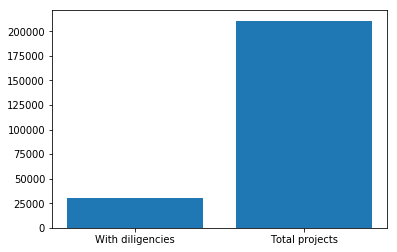

In [258]:
import matplotlib.pyplot as plt
from utils.plotter import Plotter

dd = {'With diligencies':projects_with_diligencies,
      'Total projects': total_projects}
plt.bar(dd.keys(), dd.values())
plt.show()

**Tipos distintos de diligência**

In [259]:
display(dt_diligencias['idTipoDiligencia'].unique())

array([124, 126, 181, 183, 171, 563, 564, 172, 180, 179, 174, 627])

### Adicionando data do projeto na tabela de diligências

In [260]:
dt_projetos = dt_projetos.set_index('IdPRONAC')
dt_diligencias = dt_diligencias.join(dt_projetos, on = ['idPronac'])
dt_diligencias.head()

,idPronac,idTipoDiligencia,DtSolicitacao,idSolicitante,DtResposta,idProponente,stEnviado,DtProtocolo
0,115502,124,2009-09-24 16:52:23,2851,2010-01-18 14:39:07,NaN,S,2009-08-06 16:27:50
1,114250,124,2009-09-24 18:11:00,2825,2009-10-07 19:45:18,6010.0,S,2009-06-29 15:22:16
2,115134,124,2009-09-24 18:13:00,2825,2009-10-07 16:10:21,9553.0,S,2009-07-27 15:44:16
3,114399,124,2009-09-24 18:26:00,2845,2009-10-06 09:30:35,9521.0,S,2009-07-02 15:15:34
4,115059,124,2009-09-24 18:35:00,2915,2009-10-02 18:01:47,11598.0,S,2009-07-23 11:43:45


# Limpando os dados

É conhecido que dados muito antigos (de 1992, por exemplo) podem ser inconsistentes, então vamos filtrar os dados a partir de uma data de início (2009).

In [261]:
from datetime import datetime

START_DATE = datetime(day=1, month=1, year=2013)

dt_projetos = dt_projetos[dt_projetos.loc[:, date_column] >= START_DATE]
dt_diligencias = dt_diligencias[dt_diligencias.loc[:, date_column] >= START_DATE]

## Repetindo o histograma de projetos com pelo menos uma diligência, a partir de 2013

52495


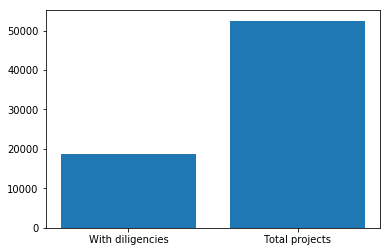

In [262]:
total_projects = len(dt_projetos)
projects_with_diligencies = len(dt_diligencias['idPronac'].unique())
print(total_projects)

dd = {'With diligencies':projects_with_diligencies,
      'Total projects': total_projects}
plt.bar(dd.keys(), dd.values())
plt.show()

## Quantidade média de diligências por projetos entre projetos com pelo menos uma diligência

In [274]:
from scipy import stats

unique, counts = np.unique(dt_diligencias.idPronac.values, return_counts=True)
pd.DataFrame(counts).describe()

,0
count,18642.000000
mean,2.160873
std,1.815752
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,40.000000


## Quantidade média de diligências por projetos entre todos os projetos

In [300]:
pronacs, diligencies = np.unique(dt_diligencias.idPronac.values, return_counts=True)
diligencies_per_project = np.append(diligencies, np.zeros(len(dt_projetos) - len(pronacs), dtype=np.int64))

pd.DataFrame(diligencies_per_project).describe()

,0
count,52495.000000
mean,0.767368
std,1.496705
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,40.000000


In [265]:
#number_of_diligencies_per_project_diligencies = [len(dt_diligencias[dt_diligencias.idPronac == idPronac]) for idPronac in dt_diligencias.idPronac]

#all_projects_diligencies_mean = np.mean(number_of_diligencies_per_project_diligencies)
#print(all_projects_diligencies_mean)